In [3]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define data transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Define train set and test set
train_set = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_set = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


100%|██████████| 9912422/9912422 [00:00<00:00, 132147899.00it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 28903768.51it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 36684019.16it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5736383.25it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define data transformations
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Define train set and test set
train_set = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_set = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Define dataloaders for train and test
batch_size = 64  # You can adjust the batch size based on your preference

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [6]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Define layers of your model
        self.fc1 = nn.Linear(28 * 28, 128)  # Input size: 28*28, Output size: 128
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # Output size: 10 (for 10 classes in MNIST)

    def forward(self, x):
        # Flatten the input image
        x = x.view(-1, 28 * 28)

        # Forward pass
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

In [7]:

# Do not change this cell
def caluculate_acc(data, model, length):
  model.eval()
  acc = 0
  for images, label in data:
    with torch.no_grad():
      images = images.to(device)
      label = label.to(device)
      yp = model(images)
      yp = torch.nn.functional.softmax(yp, dim=1)
      yp = torch.argmax(yp, 1)
      acc += torch.sum(yp == label)
  return acc / length

In [8]:

# Do not change this cell
def train_one_epoch(model, data, optimizer, criterion, length):
  model.train()
  acc = 0
  for images, labels in data:
    imgs = torch.autograd.Variable(images).to(device)
    label = torch.autograd.Variable(labels).to(device)
    optimizer.zero_grad()
    yp = model(imgs)
    loss = criterion(yp, label)
    loss.backward()
    optimizer.step()
    yp = torch.argmax(yp, 1)
    acc += torch.sum(yp == label)
  return loss.item(), acc / length

In [9]:
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary  # Make sure to install torchsummary using: pip install torchsummary

# Assuming you've defined the Model class as mentioned before
model = Model()

# Move the model to the specified device (cuda or cpu)
model.to(device)

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # You can adjust the learning rate

# Define loss
criterion = nn.CrossEntropyLoss()

# Print model summary
summary(model, (1, 28, 28))  # Assuming input size is (1, 28, 28) for MNIST


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.39
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


In [10]:

# training process
val_accs = []
accs = []
best_acc = 0
for e in tqdm(range(20)):
  accs.append(train_one_epoch(model, train_loader, optimizer, criterion, len(train_set))[1].item())
  val_accs.append(caluculate_acc(test_loader, model, len(test_set)).item())
  if best_acc < val_accs[-1]:
    torch.save(model, "model.h5")
    best_Acc = val_accs[-1]

  # just a way to avoid pverfitting
  if val_accs[-1] > 0.99 and accs[-1] > 0.99:
    break


  0%|          | 0/20 [00:00<?, ?it/s]

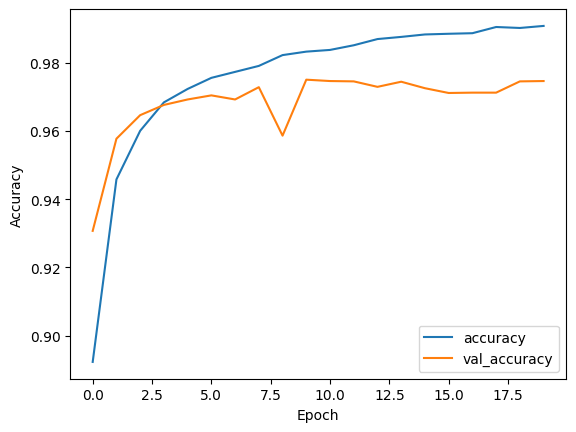

In [11]:
plt.plot(accs, label='accuracy')
plt.plot(val_accs, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show();

In [12]:
caluculate_acc(test_loader, model, len(test_set)).item(), caluculate_acc(train_loader, model, len(train_set)).item()


(0.9746000170707703, 0.9909833073616028)